Connected to .venv (Python 3.11.5)

In [1]:
# DONE
%pip install labelme tensorflow-gpu opencv-python matplotlib albumentations

  Using cached labelme-5.3.1-py3-none-any.whl
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/9b/f6/c486cedb4f75147232f32ec4c97026714cfef7c7e247a1f0427bc5489f66/albumentations-1.3.1-py3-none-any.whl.metadata
  Using cached albumentations-1.3.1-py3-none-any.whl.metadata (34 kB)
  Using cached gdown-4.7.1-py3-none-any.whl (15 kB)
  Obtaining dependency information for imgviz>=0.11 from https://files.pythonhosted.org/packages/20/23/ec40e1bc6b83ae33970ba9e9a6622d1b1f4357a3ff2b1fb5d87b0445ffa5/imgviz-1.7.4-py3-none-any.whl.metadata
  Using cached imgviz-1.7.4-py3-none-any.whl.metadata (5.6 kB)
  Obtaining dependency information for natsort>=7.1.0 from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.m

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Joey\AppData\Local\Temp\pip-install-risyqw_d\tensorflow-gpu_af9ffdfc95bc41dcb45f43803d502348\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build

In [23]:
import os
import time
import uuid
import cv2

In [4]:
IMAGE_PATH = './images/'
number_images = 30


In [9]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    imgname = './images/' +  str(uuid.uuid1()) + '.jpg'
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [13]:
# %labelme

In [20]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt


In [20]:
images = tf.data.Dataset.list_files("./images/" + "*.jpg", shuffle=False)

In [45]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(byte_img)
    return img


In [25]:
images = images.map(load_image)

In [27]:
image_generator = images.batch(4).as_numpy_iterator()

In [28]:
plot_images = image_generator.next()

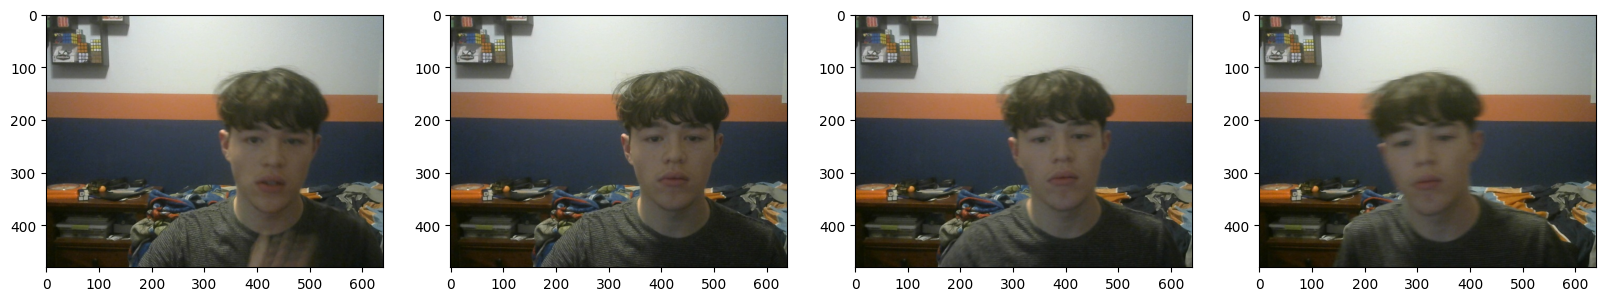

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)

In [43]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('./', folder)):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('./', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('./', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
        

In [1]:
import albumentations as alb

In [4]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [24]:
img = cv2.imread(os.path.join('train', 'images', '9faaf496-60bf-11ee-8d40-2cdb0706111a.jpg'))

In [25]:
with open(os.path.join('train', 'labels', '9faaf496-60bf-11ee-8d40-2cdb0706111a.json'), 'r') as f:
    label = json.load(f)

In [26]:
label['shapes'][0]['points']

[[321.01010101010104, 108.18181818181817],
 [523.0303030303031, 371.8181818181818]]

In [27]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [28]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes']

[(0.5866891133557801, 0.19373737373737376, 1.0, 0.7795959595959596)]

In [35]:
cv2.rectangle(augmented['image'], tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
                                  tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), 
                                  (255, 0, 0), 2)

array([[[  6,  26,  37],
        [  6,  26,  37],
        [  8,  28,  39],
        ...,
        [ 24,  26,  26],
        [ 23,  25,  25],
        [ 21,  23,  23]],

       [[  6,  28,  40],
        [  9,  28,  41],
        [  9,  28,  41],
        ...,
        [ 30,  31,  29],
        [ 27,  30,  28],
        [ 25,  27,  27]],

       [[  8,  30,  42],
        [ 11,  30,  43],
        [  9,  28,  41],
        ...,
        [ 26,  27,  25],
        [ 26,  27,  25],
        [ 24,  26,  26]],

       ...,

       [[ 51,  57,  56],
        [ 52,  58,  57],
        [ 53,  59,  58],
        ...,
        [190, 194, 189],
        [188, 192, 187],
        [189, 191, 185]],

       [[ 49,  55,  54],
        [ 51,  57,  56],
        [ 54,  60,  59],
        ...,
        [187, 191, 186],
        [187, 191, 186],
        [188, 190, 184]],

       [[ 46,  54,  53],
        [ 50,  56,  55],
        [ 53,  59,  58],
        ...,
        [185, 189, 184],
        [186, 190, 185],
        [188, 190, 184]]

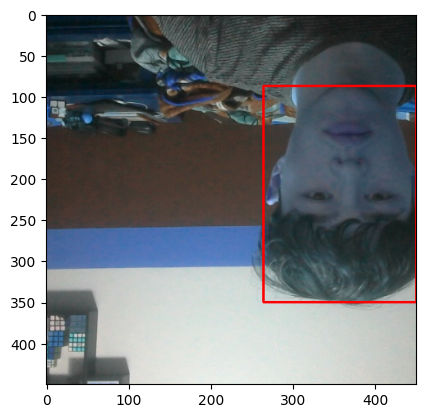

In [36]:
plt.imshow(augmented['image'])

In [43]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join(partition, 'images')):
        img = cv2.imread(os.path.join(partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [46]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [47]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [48]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [49]:
train_images.as_numpy_iterator().next()

array([[[1.9613971e-01, 1.3253677e-01, 6.3357845e-02],
        [2.2561274e-01, 1.5539216e-01, 9.6200980e-02],
        [2.2420344e-01, 1.4577205e-01, 1.0263480e-01],
        ...,
        [7.3474264e-01, 6.8768382e-01, 6.4062500e-01],
        [7.3492646e-01, 6.9491422e-01, 6.3884807e-01],
        [7.3308825e-01, 6.8602943e-01, 6.2806374e-01]],

       [[2.3008579e-01, 1.5557598e-01, 9.1850489e-02],
        [2.6035538e-01, 1.8535540e-01, 1.3192402e-01],
        [2.7837011e-01, 2.0778187e-01, 1.6856618e-01],
        ...,
        [7.3382354e-01, 6.8676472e-01, 6.3186276e-01],
        [7.2745097e-01, 6.8039215e-01, 6.2549019e-01],
        [7.2689950e-01, 6.8412989e-01, 6.3412988e-01]],

       [[1.7193627e-01, 9.7426474e-02, 3.0759804e-02],
        [2.2120099e-01, 1.4669117e-01, 8.8357843e-02],
        [3.4595588e-01, 2.7536765e-01, 2.2830883e-01],
        ...,
        [7.3419118e-01, 6.8713236e-01, 6.3223040e-01],
        [7.1899509e-01, 6.7193627e-01, 6.1703432e-01],
        [7.2653186e-01

In [50]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [53]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.6064, 0.1959, 1.    , 0.7817], dtype=float16))

In [57]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [58]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [59]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [60]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)


In [61]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.      , 0.2306  , 0.1094  , 0.6445  ],
        [0.3142  , 0.23    , 0.6567  , 0.693   ],
        [0.1783  , 0.3887  , 0.5024  , 0.8003  ],
        [0.006035, 0.2058  , 0.4036  , 0.695   ],
        [0.685   , 0.228   , 1.      , 0.7153  ],
        [0.01386 , 0.1569  , 0.495   , 0.807   ],
        [0.      , 0.04492 , 0.641   , 1.      ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [64]:
data_samples = train.as_numpy_iterator()

In [67]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


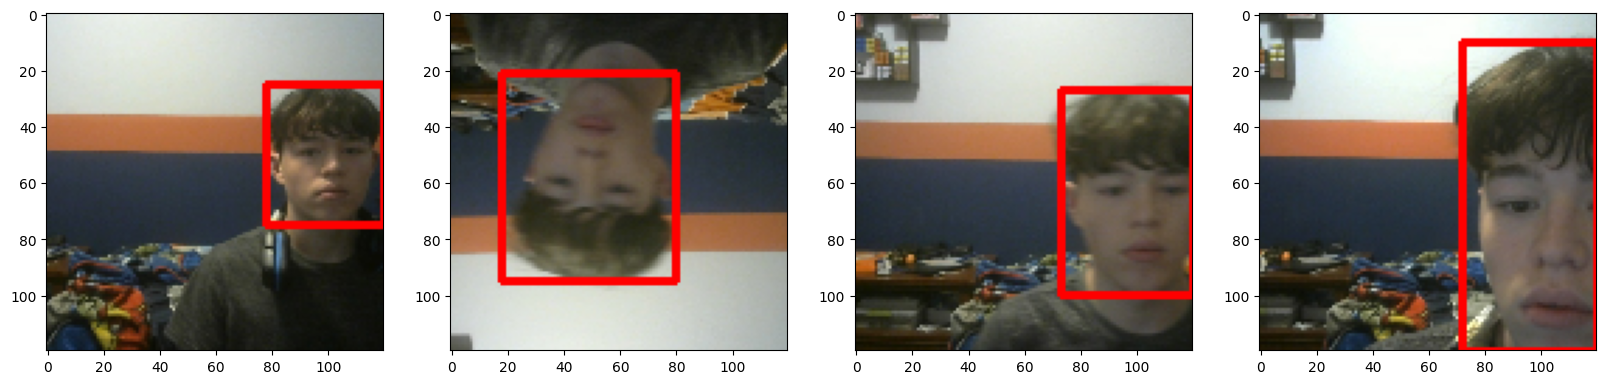

In [68]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [118]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [119]:
vgg = VGG16(include_top=False)

In [120]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [121]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [122]:
facetracker = build_model()


In [123]:
facetracker.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [124]:
X, y = train.as_numpy_iterator().next()


In [125]:
X.shape

(8, 120, 120, 3)

In [126]:

classes, coords = facetracker.predict(X)


1/1 [==============================] - 0s 382ms/step


In [127]:
classes, coords

(array([[0.33793294],
        [0.29081225],
        [0.3680529 ],
        [0.37052792],
        [0.4205491 ],
        [0.32278877],
        [0.3686137 ],
        [0.3656461 ]], dtype=float32),
 array([[0.30647436, 0.5972443 , 0.58592695, 0.44337505],
        [0.33754057, 0.61771464, 0.591199  , 0.39835888],
        [0.33499536, 0.6062154 , 0.57394904, 0.38681278],
        [0.44578612, 0.6874258 , 0.5792727 , 0.4216839 ],
        [0.33210218, 0.6075072 , 0.53120226, 0.44250938],
        [0.36482882, 0.63009036, 0.644203  , 0.43089828],
        [0.36321864, 0.63007015, 0.58984995, 0.37481695],
        [0.41980237, 0.6301965 , 0.6103112 , 0.46657595]], dtype=float32))

In [128]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [129]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [130]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [131]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1978803>

In [132]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9991082>

In [133]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1978803>

In [168]:
@keras.saving.register_keras_serializable('my_package')
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
    
    def get_config(self): 
        return self.model.get_config()
    
    @classmethod
    def from_config(cls, config): 
        return cls(**config)
    

NameError: name 'keras' is not defined

In [154]:
model = FaceTracker(facetracker)

In [155]:
model.compile(opt, classloss, regressloss)

In [156]:
logdir='logs'

In [157]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [158]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

473/473 [==============================] - 592s 1s/step - total_loss: 0.0280 - class_loss: 0.0123 - regress_loss: 0.0218 - val_total_loss: 0.0081 - val_class_loss: 0.0020 - val_regress_loss: 0.0071


In [159]:
hist.history

{'total_loss': [0.0026612812653183937],
 'class_loss': [0.0030493768863379955],
 'regress_loss': [0.001136592822149396],
 'val_total_loss': [0.008106643334031105],
 'val_class_loss': [0.00200521107763052],
 'val_regress_loss': [0.007104038260877132]}

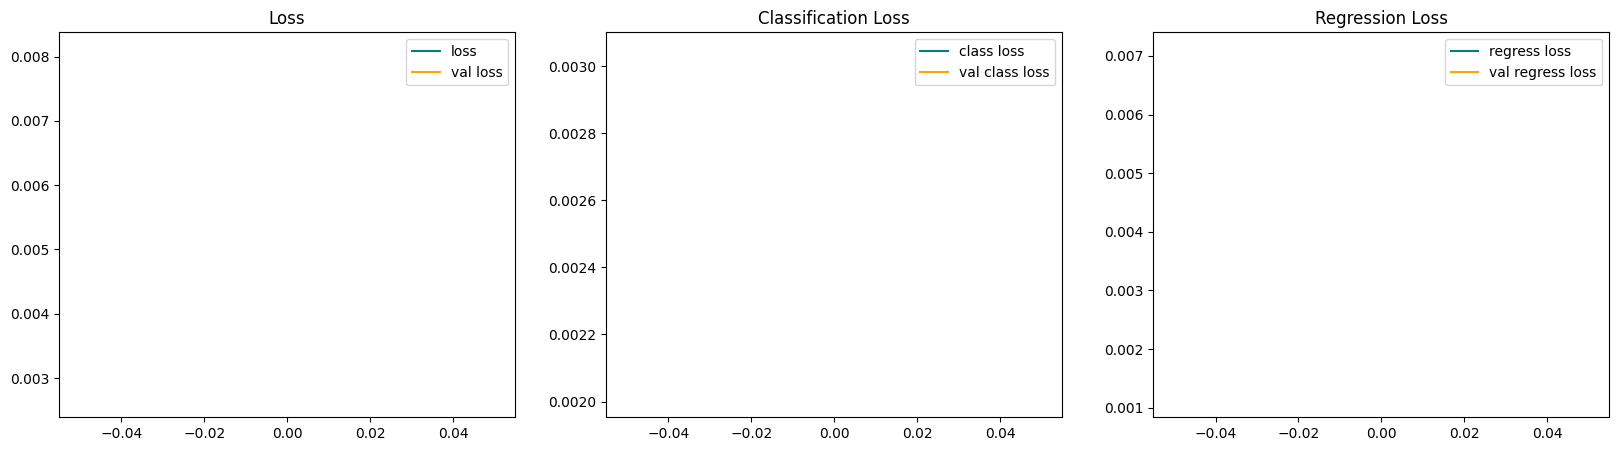

In [160]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [161]:
test_data = test.as_numpy_iterator()

In [162]:
test_sample = test_data.next()

In [163]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 311ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


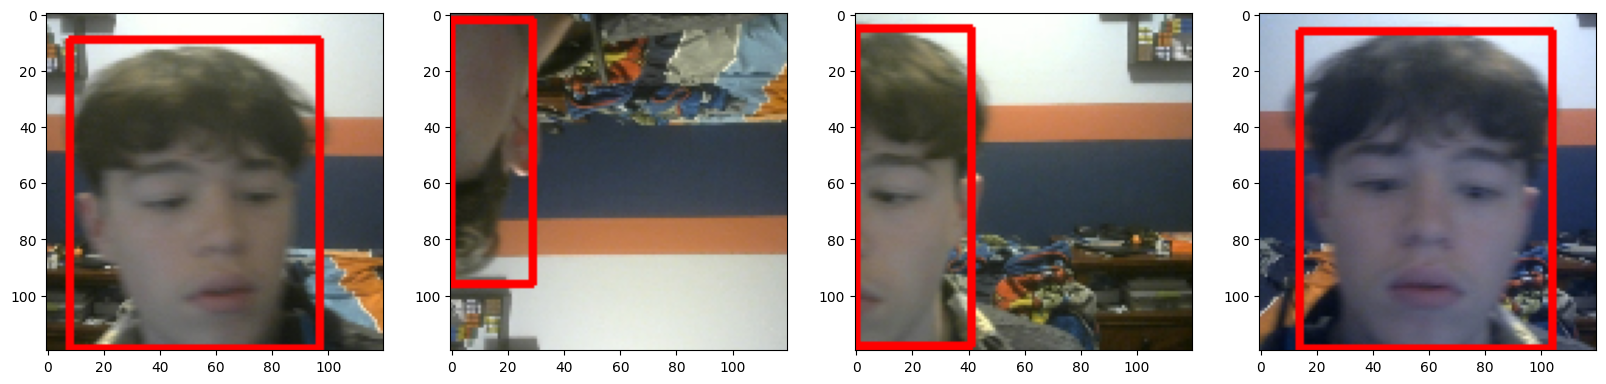

In [164]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [165]:
from tensorflow.keras.models import load_model

In [166]:
model.save('facetracker.keras')

c:\Users\Joey\Desktop\projecthub\FaceRecognition\.venv\Lib\site-packages\keras\src\saving\saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [167]:
facetracker = tf.keras.models.load_model('facetracker.keras', compile=False)

TypeError: Could not locate class 'FaceTracker'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'FaceTracker', 'config': {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 120, 120, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'vgg16', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, None, None, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_6'}, 'registered_name': None, 'name': 'input_6', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 3]}, 'name': 'block1_conv1', 'inbound_nodes': [[['input_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 64]}, 'name': 'block1_conv2', 'inbound_nodes': [[['block1_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block1_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 64]}, 'name': 'block1_pool', 'inbound_nodes': [[['block1_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 64]}, 'name': 'block2_conv1', 'inbound_nodes': [[['block1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 128]}, 'name': 'block2_conv2', 'inbound_nodes': [[['block2_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block2_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 128]}, 'name': 'block2_pool', 'inbound_nodes': [[['block2_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 128]}, 'name': 'block3_conv1', 'inbound_nodes': [[['block2_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 256]}, 'name': 'block3_conv2', 'inbound_nodes': [[['block3_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 256]}, 'name': 'block3_conv3', 'inbound_nodes': [[['block3_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block3_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 256]}, 'name': 'block3_pool', 'inbound_nodes': [[['block3_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 256]}, 'name': 'block4_conv1', 'inbound_nodes': [[['block3_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block4_conv2', 'inbound_nodes': [[['block4_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block4_conv3', 'inbound_nodes': [[['block4_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block4_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block4_pool', 'inbound_nodes': [[['block4_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block5_conv1', 'inbound_nodes': [[['block4_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block5_conv2', 'inbound_nodes': [[['block5_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block5_conv3', 'inbound_nodes': [[['block5_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block5_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 512]}, 'name': 'block5_pool', 'inbound_nodes': [[['block5_conv3', 0, 0, {}]]]}], 'input_layers': [['input_6', 0, 0]], 'output_layers': [['block5_pool', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, None, None, 3]}, 'name': 'vgg16', 'inbound_nodes': [[['input_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalMaxPooling2D', 'config': {'name': 'global_max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 512]}, 'name': 'global_max_pooling2d_2', 'inbound_nodes': [[['vgg16', 1, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalMaxPooling2D', 'config': {'name': 'global_max_pooling2d_3', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 512]}, 'name': 'global_max_pooling2d_3', 'inbound_nodes': [[['vgg16', 1, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 2048, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense_4', 'inbound_nodes': [[['global_max_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'dtype': 'float32', 'units': 2048, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense_6', 'inbound_nodes': [[['global_max_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'dense_5', 'inbound_nodes': [[['dense_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': 'float32', 'units': 4, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'dense_7', 'inbound_nodes': [[['dense_6', 0, 0, {}]]]}], 'input_layers': [['input_5', 0, 0]], 'output_layers': [['dense_5', 0, 0], ['dense_7', 0, 0]]}, 'registered_name': 'FaceTracker', 'compile_config': None}

In [151]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 62ms/step
